# Clustering using DCEC on timeseries features
Paper: https://xifengguo.github.io/papers/ICONIP17-DCEC.pdf

Note: the training of the model is done on a GUI-powered platform developed by the author

In [41]:
# load precessed training dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_pickle("../data/train.pkl")
df.tail()

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,funding_total_usd,funding_total_usd_quant,funding_rounds,last_funding_week,last_funding_week_quant,last_funding_usd,last_funding_usd_quant,invest_phase_overall,last_funding_ratio,last_funding_ratio_imp
563742,SDC Solutions,com,USA,Manchester,Communications Software Provider,"SDC Solutions, Inc., formerly System Developme...",501-1000,1814.000000,78730ded-24a9-b5ef-d11c-72b4fbd17fd6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,NaN,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",-1.0,1
563743,Advantaa Computer,,USA,Santa Ana,Advantaa Computer is operates in stealth mode.,Advantaa Computer is operates in stealth mode.,unknown,39.857143,1de43cee-8d3c-475b-aa12-6ad68dc83c27,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",...,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,NaN,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",-1.0,1
563744,Thoughty,com,USA,Santa Ana,Thoughty is a mobile application that uses loc...,Social media is here to stay and consumers aro...,1-10,250.714286,25204d2d-07d6-6d1c-6fb5-fcd8594503a3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",...,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,NaN,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",-1.0,1
563745,"Moolah, llc",cc,USA,Capistrano Beach,Accept Payments Everywhere. No Setup Fees. No ...,NaN,11-50,340.571429,86be00ad-9d43-93ae-1ace-811eb2e9cc08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",...,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,NaN,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",-1.0,1
563746,Universal Solutions Of North America,,USA,Charleston,Universal Solutions Of North America provides ...,Universal Solutions Of North America provides ...,unknown,1083.428571,aa18f7f4-d333-b75d-adf4-0204789b0415,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,NaN,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",-1.0,1


## Feature selction and formatting
The data need to be in Bigquery for a platform to work on.

In [8]:
dcec_feature_list = ['company_uuid', 'investor_names', 'investor_count', 
         'weeks_announced_quant', 'invest_phase', 'raised_amount_usd_quant', 
         'investor_count_imp', 'investor_count_log']
df = df[dcec_feature_list]
df[df.investor_names.notnull()].tail()

,company_uuid,investor_names,investor_count,weeks_announced_quant,invest_phase,raised_amount_usd_quant,investor_count_imp,investor_count_log
563733,c92610f1-89f9-5f1b-4f8b-7a6d505f8f4c,"[[0, 0, 0]]",[0],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]","[[1, 0, 0]]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[1],[0.0]
563736,5a9aeff7-00ff-6759-26d2-060818b00b6a,"[[1.0, 0.0, 0.0]]",[1],"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]","[[1, 0, 0]]","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453]
563738,6a233df2-cf8c-82f4-3aca-3988fbf4f97e,"[[0, 0, 0], [0, 0, 0]]","[0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, ...","[[1, 1, 1], [0, 1, 1]]","[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, ...","[1, 1]","[0.0, 0.0]"
563739,2275cc7f-d8c2-c69a-dc60-ee4637408367,"[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, ...","[[0, 1, 1], [0, 1, 1], [0, 1, 1], [1, 1, 1], [...","[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
563740,9fc2313a-05e8-16cb-9094-3a0ba11baec8,"[[0, 0, 0]]",[1],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]","[[0, 1, 1]]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",[0],[0.6931471805599453]


In [29]:
# Pad all timeseries to 28 elements, which is the query result from big query
cache = []
for index, row in df.iterrows():
    key = row['company_uuid']
    value = None
    if type(row['investor_count']) is not list:
        value = [0 for _ in range(868)]
    else:
        value = np.concatenate([row['investor_names'], 
                                row['invest_phase'],
                                row['weeks_announced_quant'], 
                                np.asarray(row['investor_count'])[:,np.newaxis], 
                                row['raised_amount_usd_quant'], 
                                np.asarray(row['investor_count_imp'])[:,np.newaxis], 
                                np.asarray(row['investor_count_log'])[:,np.newaxis]], axis=1).flatten()
        if len(value) > 868:
            value = value[:868]
        elif len(value) < 868:
            value = np.pad(value, (0, 868-len(value)), 'constant', constant_values=(0, 0))
        assert(len(value) == 868)
        
        # if index % 1000 == 0 and index != 0:
            # print(index)
        
    cache.append([key, value])

cdf = pd.DataFrame(cache, columns=['company_uuid', 'ts_feature'])
            
cdf.head(n=2)    

,company_uuid,ts_feature
0,51d72ce7-3075-b4d9-941f-8a90b23c9c14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,62a90659-df0d-0ff8-c30e-b393bdbbb490,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [30]:
with open('dcec.json', 'w') as f:
    f.write(cdf.to_json(orient='records')[1:-1].replace('},{', '}\n{'))

## The training is carried out on a ML-platform developed by the author
- Author's adapted code: https://github.com/caolele/DCEC_pureTF/blob/master/TF_DCEC.py 
- It will be demostrated in the readme
- the prediction result is exported to BQ and then as a json file
- No whatsoever hparams tuning; they are set to empirically values on other datasets.

## Evaluation

In [100]:
dff = pd.read_json('./dcec_pred.json', lines = True)
dff.head(n=5)

,company_uuid,code,cluster_kmeans,cluster,index
0,8358e79f-e156-de15-cbf2-28f36efe11ac,"[0.23609749972820201, -0.38421797752380304, 0....",0,0,100001
1,c51d30d2-5751-52b8-84c7-98e4983e3ea4,"[0.23609749972820201, -0.38421797752380304, 0....",0,0,100002
2,5bfdd63f-36bd-0f5a-22fc-7af5b17da952,"[0.23609749972820201, -0.38421797752380304, 0....",0,0,100003
3,e7e57f3b-a498-89a5-e726-4f4edc242365,"[0.23609749972820201, -0.38421797752380304, 0....",0,0,100004
4,28227f94-3ff3-48ae-8db4-e79d7978d6ac,"[0.23609749972820201, -0.38421797752380304, 0....",0,0,100005


In [34]:
dff_sample = dff.sample(n = 2000) 
z = pd.DataFrame(list(dff_sample.iloc[:,1]))
z.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.236097,-0.384218,0.108664,-0.15516,-0.290845,-0.129456,0.375291,-0.233593,-0.418884,0.19555,-0.258846,0.441185,0.260651,0.286615,-0.286053,0.334374
1,0.236097,-0.384218,0.108664,-0.15516,-0.290845,-0.129456,0.375291,-0.233593,-0.418884,0.19555,-0.258846,0.441185,0.260651,0.286615,-0.286053,0.334374
2,0.236097,-0.384218,0.108664,-0.15516,-0.290845,-0.129456,0.375291,-0.233593,-0.418884,0.19555,-0.258846,0.441185,0.260651,0.286615,-0.286053,0.334374
3,-1.374545,4.535708,-1.334287,0.09064,1.586709,-0.832467,-3.054692,-0.886272,2.027337,-0.82584,0.202020,-1.463318,-1.176805,-1.629706,2.337574,-3.577415
4,0.236097,-0.384218,0.108664,-0.15516,-0.290845,-0.129456,0.375291,-0.233593,-0.418884,0.19555,-0.258846,0.441185,0.260651,0.286615,-0.286053,0.334374


### TSNE Visualization of encoding

In [35]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_res = tsne.fit_transform(z)
res_pd = pd.DataFrame(tsne_res)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.004s...
[t-SNE] Computed neighbors for 2000 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.315338
[t-SNE] KL divergence after 1000 iterations: 1.920230


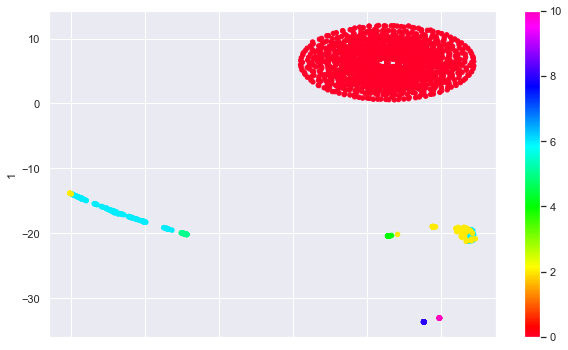

In [36]:
colors = dff_sample.iloc[:,3].values
res_pd = pd.DataFrame(tsne_res)
sns.set(rc={'figure.figsize':(10,6)})
res_pd.plot.scatter(x=0, y=1, c=colors, colormap='gist_rainbow')

## Explain the clusters
Due to limited time, only one illustration is provided

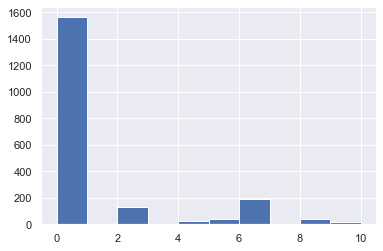

In [101]:
# cluster balancing
sns.set(rc={'figure.figsize':(6,4)})
g=dff_sample['cluster'].hist()

In [129]:
zf = pd.merge(df, dff, on='company_uuid', how='left')
print(zf.shape)

(563747, 35)


### Distplot: cluster vs. features
Due to limited time, only a few examples are illustrated here

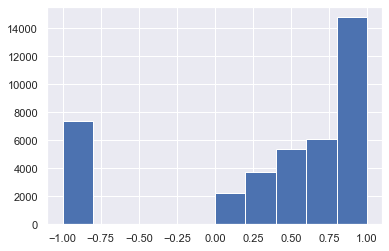

In [134]:
zf[zf.cluster==2]['last_funding_ratio'].hist()

/Users/lelecao/anaconda3/envs/py36tf19/lib/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


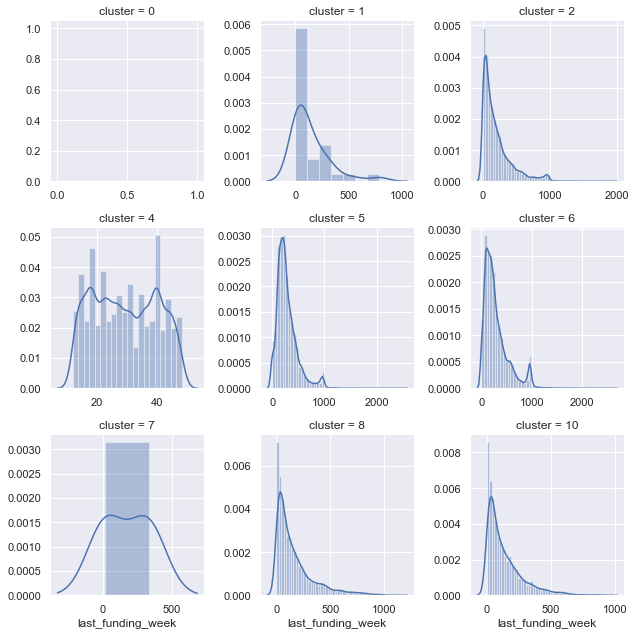

In [109]:
g = sns.FacetGrid(zf, col="cluster", col_wrap=3, sharex=False, sharey=False)
g.map(sns.distplot, "last_funding_week")

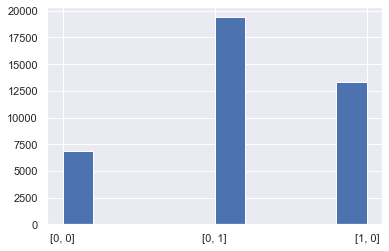

In [136]:
zf[zf.cluster==2]['invest_phase_overall'].apply(str).hist()
# Note that [0, 1] refers to pre A/B series

### Cluster 4 seems to be an interesting group
Further filter on last_funding_week

In [144]:
zf = zf[zf.cluster == 2]
zf = zf[zf.last_funding_week <= 12]
zf = zf[zf.last_funding_usd > 10000]
zf = zf[zf['invest_phase_overall'].apply(lambda x: x == [0, 1])]
zf = zf[zf.last_funding_ratio > 0.1]
zf

,company_name,homepage_url,country_code,city,short_description,description,employee_count,weeks_founded,company_uuid,weeks_founded_quant,...,last_funding_week_quant,last_funding_usd,last_funding_usd_quant,invest_phase_overall,last_funding_ratio,last_funding_ratio_imp,code,cluster_kmeans,cluster,index
550,Virtuleap,com,PRT,Lisbon,VR Brain Training for Cognitive Health,Virtuleap's VR brain training app offers a dai...,1-10,35.714286,b0ac15fc-b536-1e6d-53a5-e8bbf68d5f17,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",125000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",0.714286,0,"[-2.052242517471313, 5.437999725341796, -2.020...",2,2,12810
1075,Monarc Inc.,com,,,Monarc is a sports robotics and IoT company th...,NaN,1-10,97.714286,d1e3fc8c-b75d-47a2-8acf-bfc5a014422e,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",100001.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",1.000000,0,"[-1.8494794368743892, 4.743738174438476, -1.41...",2,2,45379
1427,Sokowatch,com,KEN,Nairobi,Sokowatch provides multinational companies wit...,Sokowatch provides multinational companies wit...,1-10,300.714286,009544b3-511a-4fe8-89f0-4af7a57aa204,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",2000000.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 1]",1.000000,0,"[-2.140554189682006, 5.300793647766113, -1.841...",2,2,543051
1467,Gopanza,com,PRI,Guaynabo,Gopanza digitally transforms Brick and Mortar ...,Gopanza provides a white labeled SaaS grocerie...,1-10,92.000000,7844364c-790c-429e-90d6-56ca88651c67,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",40000.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",0.666667,0,"[-1.8205580711364742, 5.343617439270019, -1.36...",2,2,487729
1596,Cognicept Systems,systems,SGP,Singapore,We step in when robots get confused. We provid...,Cognicept provides Human-in-the-loop (HITL) er...,1-10,5.142857,1fd49a37-3582-4b72-b926-71046b8ccb2f,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",100000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",1.000000,0,"[-1.724629878997802, 4.701897621154785, -1.490...",2,2,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561557,Trufan,io,CAN,Toronto,Trufan is an audience management platform that...,Trufan is an audience management platform that...,1-10,44.285714,e6bfcd7f-abbe-40e9-b21d-465815a273dc,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",500000.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1]",0.952381,0,"[-2.021743535995483, 5.230198860168457, -2.200...",2,2,413963
561778,Wootzano,com,GBR,Edinburgh,Wootzano allows robots and autonomous systems ...,Wootzano allows robots to sense and feel like ...,1-10,20.857143,044220e0-c9b2-432e-8271-fa403f50c39c,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",98002.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",0.578753,0,"[-1.5173412561416622, 5.339869499206543, -0.73...",2,2,49307
561979,QuantHUB,com,USA,Birmingham,QuantHUB is an AI-driven Platform for Attracti...,QuantHUB is an AI-driven Platform for Attracti...,1-10,39.857143,bc659a96-fb86-4296-8f92-c7e9840048a7,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1250000.0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1]",1.000000,0,"[-1.858577489852905, 4.8287763595581055, -2.28...",2,2,166513
562729,Hosping Inc.,com,CHL,Santiago,hosping is a software (SaaS) that helps hoteli...,NaN,11-50,123.714286,2131ddd8-11ff-47c3-9e4a-9417f37f3cfe,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",150000.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1]",1.000000,0,"[-1.680239796638488, 4.580793380737304, -1.589...",2,2,145469


### Check company profile semantics

In [145]:
#r5: Semantic Similarity
import pickle
infile = open('../model/semdb_model.pkl','rb')
model = pickle.load(infile)
infile.close()

from bfs import filter_on_similarity
focus_orgs = filter_on_similarity(zf, model, 0.3)
print('Found {} groups of companies that may be of interest!'.format(len(focus_orgs)))

BFSing ...
Found 10 groups of companies that may be of interest!


In [146]:
# Sample several companies for each group
frames = []
seq_no = 1
for group in focus_orgs:
    n = len(group)
    # idx = np.random.choice(n, 3, replace=False)
    print('Group {}: Total {} companies.'.format(seq_no, n))
    # focus_orgs_list = focus_orgs_list.union(group)
    print(df.loc[list(group)[:10]]['short_description'].to_string())
    
    tmp = pd.DataFrame(list(group), columns =['id'])
    tmp['group'] = [seq_no for _ in range(n)]
    frames.append(tmp)
    
    seq_no += 1
    
focus_orgs_df = pd.concat(frames)

Group 1: Total 305 companies.
537090    DART Diagnostics work with the purpose of impr...
121347    Applied Cavitation Technologies develops and t...
375815    LuxAI is an innovative startup specialized in ...
290312    Volvero is an app based on the most innovative...
326152    TSE Systems is a globally renowned manufacture...
154634    HAKOM Solutions is the first integrated optimi...
284172    Wearable technology from sensing and tracking ...
256525                 RealSynth is the virtual gym for AI.
145934    Corti is a machine learning company that helps...
449549    a (Cloud) software platform delivering very ef...
Group 2: Total 169 companies.
97803     African Information Technology Solutions Provider
307212                        Entis is a insect food brand.
105997                            Live it. Map it. Find it.
155151    Inspiring the world to practice mental wellnes...
313367    Parkwheels aims at solving the big, bad & unse...
483351    Our mission is to celebrate wo

## Test on the hold-out data¶

In [148]:
uuid_holdout = list(zf.loc[list(focus_orgs_df['id'])]['company_uuid'])
sql = """
SELECT
  SUM(raised_amount_usd)
FROM
  `proj.leleca.mbt_funding`
WHERE
  announced_on > "2018-10-07"
  AND company_uuid IN ("{}")
""".format('","'.join(map(str, uuid_holdout)))
print(sql)
usd_sum_holdout_selected = 814493304
n_orgs_holdout_selected = 317 # len(uuid_holdout)
print('Selected companies ({}) obtain a total of USD = {}'.format(n_orgs_holdout_selected, usd_sum_holdout_selected))


SELECT
  SUM(raised_amount_usd)
FROM
  `proj.leleca.mbt_funding`
WHERE
  announced_on > "2018-10-07"
  AND company_uuid IN ("3c4e33fe-dc5e-47d4-b1f0-0f267139946f","5cd34b0e-2683-40c9-9b3e-7f8a5dac318a","d8440f8a-3e0b-bb00-978d-f0d22dab3d6a","3d8cfe1e-ae5e-4c93-bdab-280bc3b87a70","28841c8c-01f6-4f61-a7bd-832ad05e00dd","988b906a-247e-4840-87b3-a42de6044d79","f24ae393-09c8-79f4-dd75-b0e795eb9ce7","c180b1aa-38c3-cd61-8f05-6d6924758486","a6628316-7786-751d-aca4-2f44456da682","2d0a14bd-9f5f-510c-ec99-17f9f6cc36e5","073fc752-7bb5-f259-304c-f558fe154e15","e04246e8-8174-6789-3f78-d50a8e3b4991","8531efcc-c099-538f-48f5-3924238fd8b8","6a3538cd-0612-49fe-aeae-6000db73b8cc","56204e23-2403-4a99-0c62-cf1b168bc1d7","3c5b6230-6146-453e-8b34-b332a20ea3f2","3846a532-2b82-4442-8475-33720b9517aa","9ccad7d9-32c6-473d-a763-2df6e722d16a","5d5ad5e4-ffd2-4d7a-a73e-287cfb046c05","b0ac15fc-b536-1e6d-53a5-e8bbf68d5f17","43a903a5-bfce-98f5-43f9-bd1210de178e","eafdca04-5cb8-4fef-88d7-e058fd2fc2f3","b13c217c-adf6-44

In [149]:
n_orgs_holdout_preab, usd_sum_holdout_preab, avg_original = 14119, 22460304700.0, 1590785.7992775692

print('1. Percentage of USD for the selected companies: {} %'.format(usd_sum_holdout_selected*100/usd_sum_holdout_preab))
avg_selected = usd_sum_holdout_selected/n_orgs_holdout_selected
print('2. Average USD for the selected companies: {}, which is {} times of average.'.format(
    avg_selected, avg_selected/avg_original))
print('3. Among the selcted companies, {} % actually received funds afterwards.'.format(
    n_orgs_holdout_selected*100/len(uuid_holdout)))


1. Percentage of USD for the selected companies: 3.626368007376142 %
2. Average USD for the selected companies: 2569379.5078864354, which is 1.615163719121254 times of average.
3. Among the selcted companies, 35.458612975391496 % actually received funds afterwards.
